<a href="https://colab.research.google.com/github/kridtapon/WFO-Adaptive-Price-Hull-MA-Crossover/blob/main/WFO_Adaptive_Price_Hull_MA_Crossover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
<ipython-input-41-799b8d3f1ee6>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-799b8d3f1ee6>:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-799b8d3f1ee6>:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide


Walk-Forward Optimization Results:
   Year Best_Params  Test_Return
0  2020   (80, 109)     0.058425
1  2021   (80, 122)     0.283620
2  2022   (37, 153)    -0.369969
3  2023   (49, 174)     1.453927
4  2024   (49, 174)     0.397552
5  2025   (41, 123)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           299931.116301
Total Return [%]                       199.931116
Benchmark Return [%]                   180.172876
Max Gross Exposure [%]                      100.0
Total Fees Paid                        3906.87063
Max Drawdown [%]                        43.927422
Max Drawdown Duration                       409.0
Total Trades                                   14
Total Closed Trades                            13
Total Open Trades                               1
Open Trade PnL                   

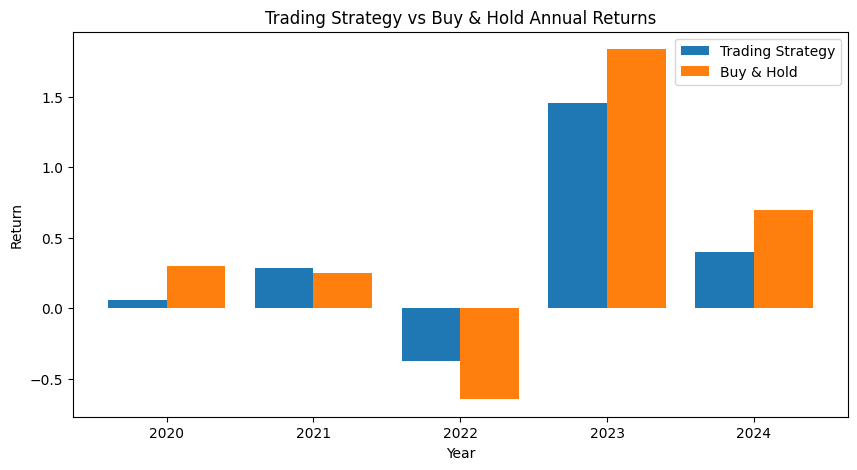

In [41]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Define function to calculate typical price
def typical_price(df):
    return (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

# Function to calculate Hull Moving Average (HMA)
def hull_moving_average(df, window):
    """ Calculate Hull Moving Average (HMA) for a given window. """
    half_window = window // 2
    sqrt_window = int(np.sqrt(window))

    # Weighted moving average (WMA) of half window
    wma_half = df['TP'].rolling(window=half_window).mean()

    # WMA of full window
    wma_full = df['TP'].rolling(window=window).mean()

    # WMA of the difference of the full and half WMA
    hull_ma = (2 * wma_half - wma_full).rolling(window=sqrt_window).mean()

    return hull_ma

# Function to calculate moving averages with HMA crossover
def moving_average_crossover(df, short_window=50, long_window=200):
    df['TP'] = typical_price(df)  # Calculate typical price

    # Calculate Hull Moving Averages
    df['Short_HMA'] = hull_moving_average(df, short_window)
    df['Long_HMA'] = hull_moving_average(df, long_window)

    df['Entry'] = df['Short_HMA'] > df['Long_HMA']  # Buy when short HMA crosses above long HMA
    df['Exit'] = df['Short_HMA'] < df['Long_HMA']  # Sell when short HMA crosses below long HMA

    return df

# Walk-forward optimization with HMA crossover strategy
def walk_forward_optimization_ma(df, start_year, end_year):
    results = []

    # Define dynamic ranges for short and long windows
    short_window_range = range(1, 101)  # Range for short HMA windows
    long_window_range = range(101, 201)  # Range for long HMA windows

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of short and long windows
        for params in itertools.product(short_window_range, long_window_range):
            short_window, long_window = params

            # Calculate moving averages on the training data
            train_data = moving_average_crossover(train_data, short_window, long_window)

            # Generate entry and exit signals based on HMA crossover
            entries = train_data['Entry']
            exits = train_data['Exit']

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (short_window, long_window)

        # Test with the best parameters on the test data
        # Extend the data range to include the previous year for indicator calculation
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply moving averages
        yearly_data = moving_average_crossover(yearly_data, best_params[0], best_params[1])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = yearly_data['Entry']
        exits = yearly_data['Exit']

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'META'  # META! TPL!
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_ma(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply moving averages
    yearly_data = moving_average_crossover(yearly_data, params[0], params[1])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = yearly_data['Entry']
    exits = yearly_data['Exit']

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [42]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,280172.876053
Total Return [%],180.172876
Benchmark Return [%],180.172876
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],76.73609
